<a href="https://colab.research.google.com/github/techsidh/Amazon-reviews-sentiment-analysis/blob/main/Amazon_Review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Sentiment Analysis of Amazon's customer reviews**

**Introduction to the Case study**

**Business Context** 

You are a data scientist for a large e-commerce firm. You have tens of thousands of customers writing reviews on products each day. Each review contains textual feedback along with a 1-to-5 star rating system (1 being least satisfied and 5 being most satisfied). The firm wants to quantify customer satisfaction coming from these non-rated interactions to help with further business decisions.

**Business Problem**

Your task is to build models which can identify the sentiment (positive or negative) of each of these non-rated interactions.

**Analytical Context**

The data is a set of reviews in CSV file format. We will combine some text processing procedures to be learnt in this session and classification models to develop algorithms capable of classifying interactions by sentiment.

You'll be doing the following in this case:

1. Read and analyze the input text data and the corresponding response variables (ratings)
2. Perform basic pre-processing to prepare the data for modeling
3. Learn and apply various ways of featurizing the reviews text
4. Build machine learning models to classify text as either exhibiting positive or negative sentiment (1 or 0).

In [21]:
#general libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#NLP libraries

import nltk
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from collections import Counter
from wordcloud import WordCloud

#Modeling libraries

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score,precision_score,recall_score

from pylab import rcParams
import warnings
warnings.filterwarnings("ignore")

rcParams['figure.figsize'] = 14, 6
plt.style.use('ggplot')

In this way, the following attributes are available in the data:

1. Id (numerical): start and end date of the attack in timestamp format.
2. ProductId (categorical): ID of the referenced product by the customer.
3. UserId (categorical): registered user ID.
4. ProfileName (text): registered user profile name.
5. HelpfulnessNumerator (numerical): number of users who found the review helpful.
6. HelpfulnessDenominator (numerical): Number of users who voted whether the review was helpful or not.
7. Score (ordinal): rating between 1 and 5.
8. Time (numerical): timestamp of the review.
9. Summary (text): brief summary of the review.
10. Text (text): text of the review.


#Reading and performing basic analysis of the data
As usual the first step is to read the available data and perform some high-level analysis on it:

In [22]:
amazon_reviews = pd.read_csv('https://media.githubusercontent.com/media/juliandariomirandacalle/NLP_Notebooks/master/01-Introduction_NLP/Customer_Reviews.csv')
amazon_reviews.shape

(10000, 9)

In [23]:
amazon_reviews.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [24]:
amazon_reviews.tail()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
9995,B000P41A28,A3A63RACXR1XIL,"A. Boodhoo ""deaddodo""",10,15,1,1204502400,constipation,we switched from the advance similac to the or...
9996,B000P41A28,A5VVRGL8JA7R,Adam,2,3,5,1306368000,Constipation Not A Problem if...,"Like the bad reviews say, the organic formula ..."
9997,B000P41A28,A2TGDTJ8YCU6PD,geena77,0,0,5,1347494400,Love this formula!,I wanted to solely breastfeed but was unable t...
9998,B000P41A28,AUV4GIZZE693O,"Susan Coe ""sueysis""",1,2,5,1203638400,very convenient,i love the fact that i can get this delieved t...
9999,B000P41A28,A82WIMR4RSVLI,Emrose mom,0,1,4,1337472000,The best weve tried so far,We have a 7 week old... He had gas and constip...


In [25]:
amazon_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ProductId               10000 non-null  object
 1   UserId                  10000 non-null  object
 2   ProfileName             10000 non-null  object
 3   HelpfulnessNumerator    10000 non-null  int64 
 4   HelpfulnessDenominator  10000 non-null  int64 
 5   Score                   10000 non-null  int64 
 6   Time                    10000 non-null  int64 
 7   Summary                 10000 non-null  object
 8   Text                    10000 non-null  object
dtypes: int64(4), object(5)
memory usage: 703.2+ KB


In [26]:
amazon_reviews.describe()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,10000.000000,10000.000000,10000.000000,1.000000e+04
mean,1.573500,2.014900,4.134500,1.294359e+09
std,5.230634,5.807551,1.327172,4.769699e+07
min,0.000000,0.000000,1.000000,9.617184e+08
25%,0.000000,0.000000,4.000000,1.268762e+09
50%,0.000000,1.000000,5.000000,1.307837e+09
75%,2.000000,2.000000,5.000000,1.329955e+09
max,187.000000,216.000000,5.000000,1.351210e+09


Let's look at the distribution of number of words per review. We will do this by applying a lambda function that splits each complete review by spaces, which will give us the borad words:

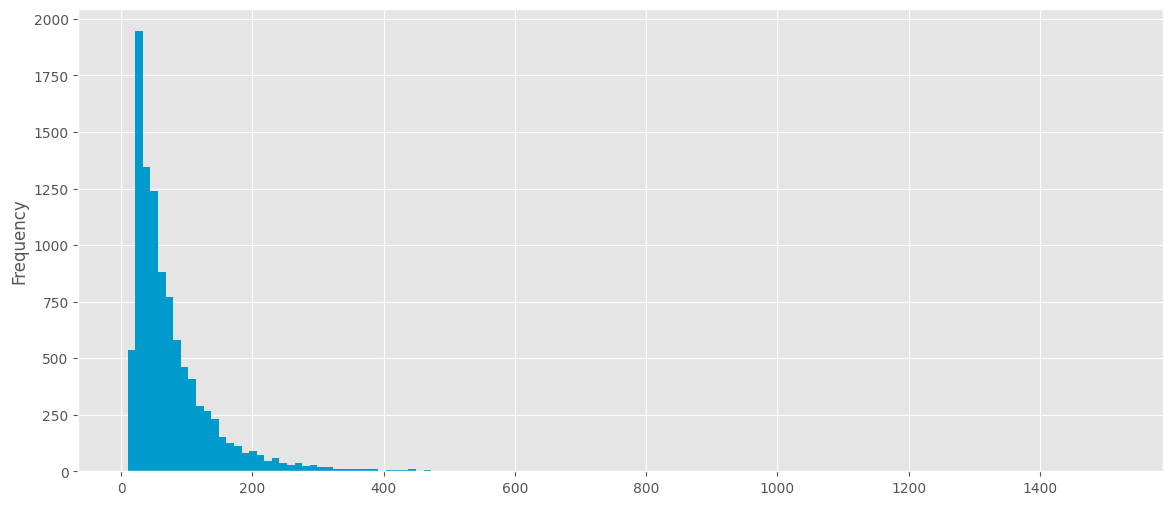

In [27]:
color = ['#009ACD', '#ADD8E6', '#63D1F4', '#0EBFE9','#C1F0F6', '#0099CC']
word_per_review = amazon_reviews.Text.apply(lambda x:len(x.split(" "))).plot(kind ='hist',bins = 130,color = color)

## Check distibution of rating


In [28]:
percent_val = 100*amazon_reviews['Score'].value_counts(normalize = True)
percent_val

5    61.83
4    14.33
1     9.32
3     8.62
2     5.90
Name: Score, dtype: float64

<Axes: ylabel='Score'>

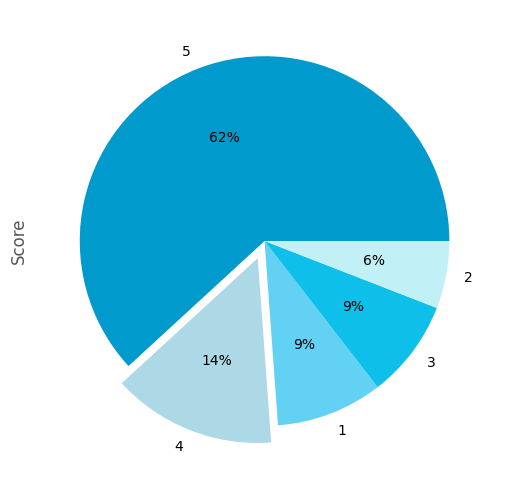

In [29]:

color = ['#009ACD', '#ADD8E6', '#63D1F4', '#0EBFE9','#C1F0F6', '#0099CC']
percent_val.plot(kind = 'pie',autopct='%.0f%%',explode = [0, 0.1, 0 , 0, 0],colors = color)



The distribution is quite skewed, with a giant number of 5s and very few 3s, 2s, and 1s.

## Check users who found the review helpful

<Axes: ylabel='Frequency'>

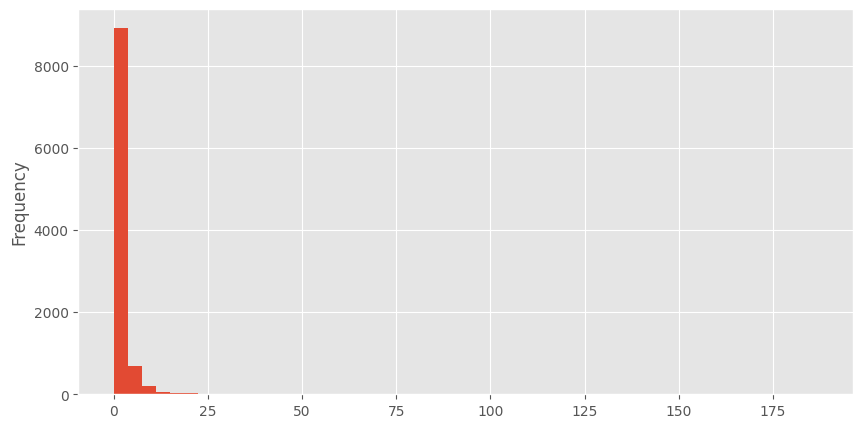

In [30]:
plt.figure(figsize = (10,5))
amazon_reviews['HelpfulnessNumerator'].plot(kind = 'hist',bins = 50)

<Axes: ylabel='Frequency'>

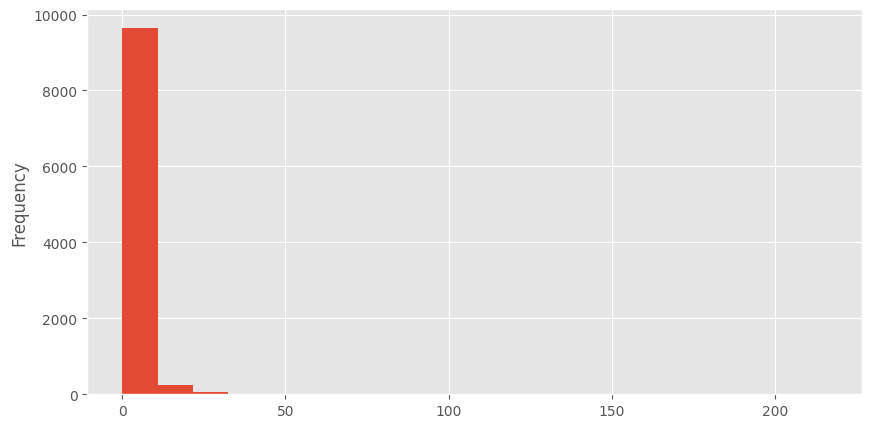

In [31]:
plt.figure(figsize = (10,5))
amazon_reviews['HelpfulnessDenominator'].plot(kind = 'hist',bins = 20)


#Text visualization using word clouds (word clouds )
As visualization is crucial for numerical data, it is also important for text data. However, the text does not lend itself to histogram charts or scatterplots, as numerical data does. In such cases, the word clouds are a common and very useful tool to appreciate the text distribution.


For the this we are going to import wordcloud package.

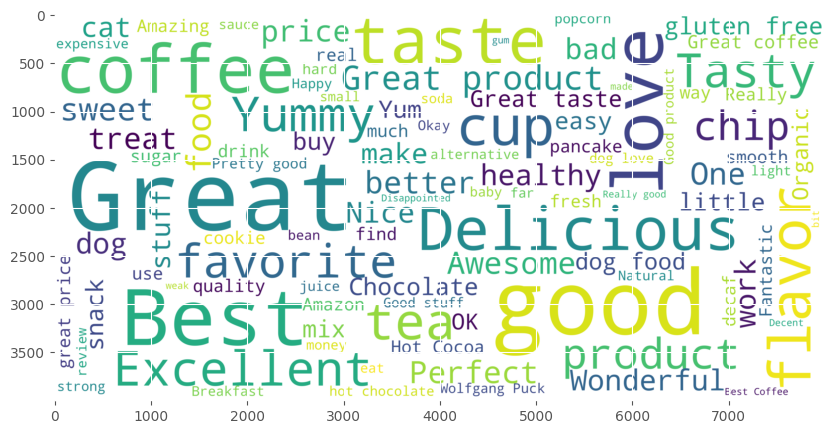

In [32]:
word_cloud_summary = " ".join(amazon_reviews['Summary'])

word_summary = WordCloud(max_font_size = 100,
                         max_words = 100,
                         background_color='white',
                         scale = 10,
                         width = 800,
                         height = 400).generate(word_cloud_summary)

plt.figure(figsize = (10,5))
plt.imshow(word_summary,
           interpolation = 'bilinear')

The word cloud indicates that many of the reviews talk about summary-related things - Great,Coffee,Delicious,favorite,excellent. We also see some positive words like good, love, best, as well as not desired ones such as br (line break), many (determiner) and something (adverb).

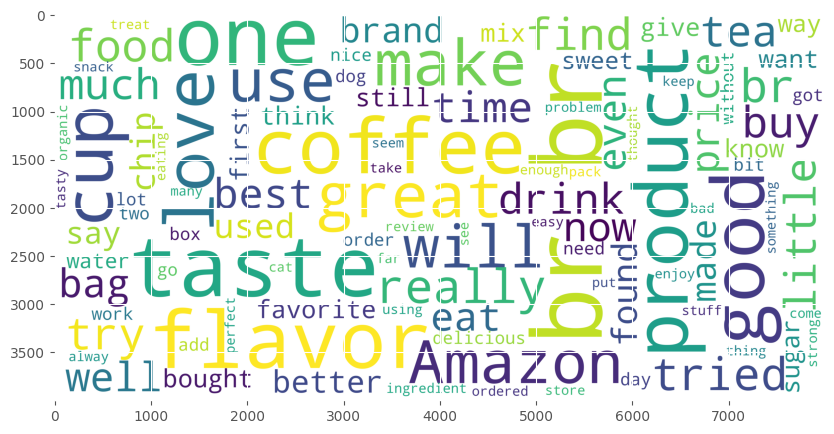

In [33]:
word_cloud_text = "".join(amazon_reviews['Text'])

word_cloud = WordCloud(max_font_size = 100,
                       max_words = 100,
                       background_color = "white",
                       scale = 10,
                       width = 800,
                       height = 400).generate(word_cloud_text)

plt.figure(figsize = (10,5))
plt.imshow(word_cloud)
      


The word cloud indicates that many of the reviews talk about food-related things - coffee, flavor, food, taste, drink. We also see some positive words like good, love, best, as well as not desired ones such as br (line break), many (determiner) and something (adverb).


#**Standardizing the ratings for sentiment analysis (5 mts)**
For the purposes of sentiment analysis, we will convert all of the ratings into binary values using the follow rule:

* Ratings of 4 or 5 will get mapped to 1 and will be reltead to positive reviews
* Ratings of 1 or 2 will get mapped to 0 and will be related to negative reviews
* Ratings of 3 will get removed since they will represent neutral reviews.



In [34]:
amazon_reviews['Sentimenta_scores'] = np.where(amazon_reviews['Score'] > 3,1,0)
amazon_reviews = amazon_reviews[amazon_reviews['Score']!=3]
100*amazon_reviews['Sentimenta_scores'].value_counts(normalize = True)

1    83.344277
0    16.655723
Name: Sentimenta_scores, dtype: float64

<Axes: xlabel='Sentimenta_scores', ylabel='count'>

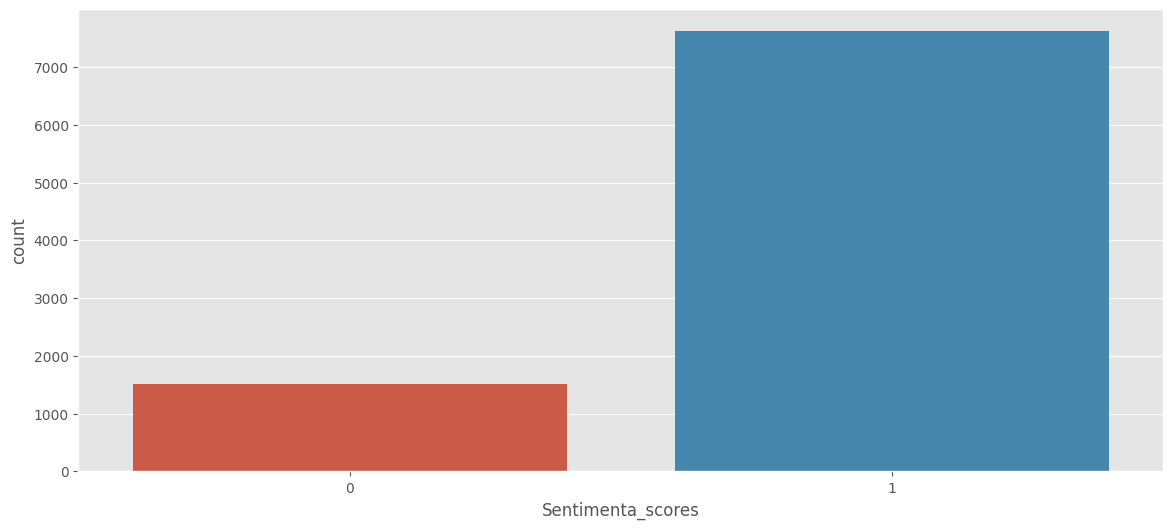

In [35]:
sns.countplot(x = amazon_reviews['Sentimenta_scores'],data = amazon_reviews)

There is huge a class imbalance that we are going to handle by defining robust metrics


#Pre-processing 

As discussed previously, text preprocessing and normalization is crucial before building a proper NLP model. Some of the important steps are:

Converting words to lower/upper case
Removing special characters
Removing stopwords and high/low-frequency words
Stemming/lemmatization


In [36]:
import nltk 
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [37]:
word_tokenize("I'm belonging from Bihar and born and brought up Mumbai")

['I',
 "'m",
 'belonging',
 'from',
 'Bihar',
 'and',
 'born',
 'and',
 'brought',
 'up',
 'Mumbai']

1. Converting words to lower/upper case
Let's start by converting all of the words into a consistent case format, say lowercase:

In [38]:
#1. Converting words to lower/upper case
amazon_reviews['reviews_text_new'] = amazon_reviews['Text'].str.lower()

In the following code cell we analyze the number of unique words that are found in reviews before and after applying this step. This process of extracting individual words is called word tokenization, and can be run using the word_tokenize function in the nltk package:

In [39]:
# For reviews not converted to lower case
token_list = [word_tokenize(each) for each in amazon_reviews['Text']]
token = [word for sublist in token_list for word in sublist]
token_list = len(set(token))
print("Without lower case: ",token_list)

# For reviews converted to lower case
token_list_lower = [word_tokenize(each) for each in amazon_reviews['reviews_text_new']]
token_lower = [word for sublist in token_list_lower for word in sublist]
token_list_lc = len(set(token_lower))
print("With lower case: ",token_list_lc)


Without lower case:  27509
With lower case:  22473


<Axes: >

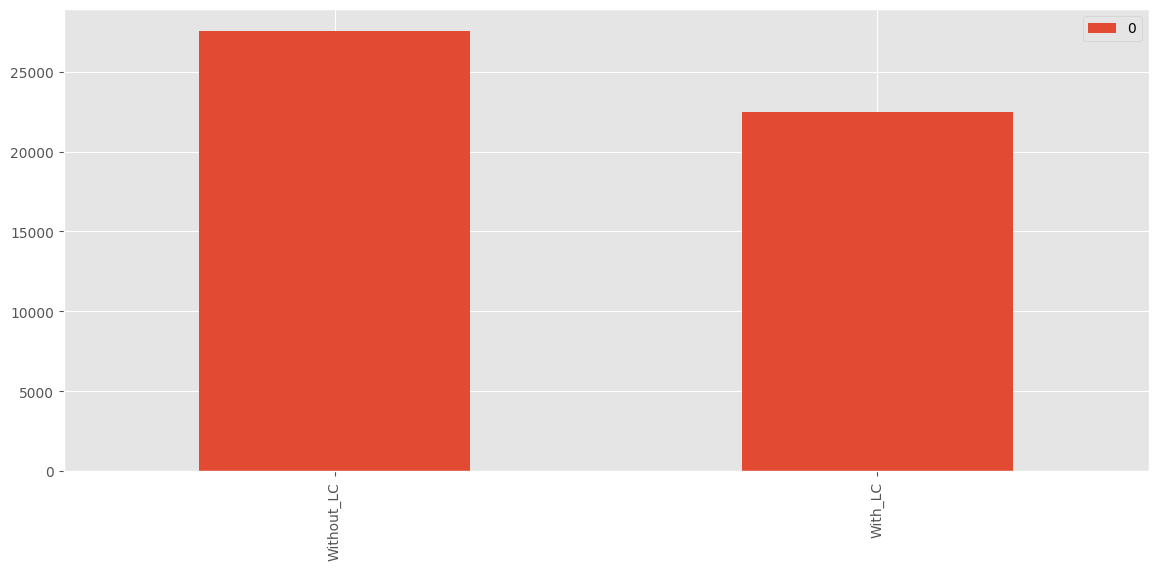

In [40]:
index = ['Without_LC','With_LC']
df = pd.DataFrame(data = [token_list,token_list_lc],index = index)
df.plot(kind = 'bar')


The number of tokens has gone down by ~18% just from normalizing the corpus.

Removing special characters is a subjective call, especially in cases like this one. People often use special characters to express their emotions and might leave a review like 'This product is the worst!!!', while a positive review could be like 'This product is the best. Loved it!'. Here, the presence of exclamation marks clearly indicates something about the underlying sentiment, so removing them may well not be a good idea.

On the other hand, removing non-emotionally charged punctuation such as commas, periods, and semicolons is likely safe.



#2. Removing special characters
For the sake of simplicity, we will proceed by removing all of the special characters; however, it pays to keep in mind that this is something to revisit depending on the results we get later. The following gives a list of all the special characters in our dataset:

In [41]:
amazon_reviews['Text'][5]

'I got a wild hair for taffy and ordered this five pound bag. The taffy was all very enjoyable with many flavors: watermelon, root beer, melon, peppermint, grape, etc. My only complaint is there was a bit too much red/black licorice-flavored pieces (just not my particular favorites). Between me, my kids, and my husband, this lasted only two weeks! I would recommend this brand of taffy -- it was a delightful treat.'

In [42]:
spl_review = amazon_reviews['reviews_text_new'].apply(lambda review:[char for char in list(review) if not char.isalnum() and char != ' '])
flat_flatten = [item for sublist in spl_review for item in sublist]
set(flat_flatten)


{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 ']',
 '^',
 '_',
 '`',
 '{',
 '}',
 '~',
 '§',
 '®'}

Let's remove these special characters from the reviews by applying a regular expression:

In [43]:
review_backup = amazon_reviews['reviews_text_new'].copy()
amazon_reviews['reviews_text_new'] = amazon_reviews['reviews_text_new'].str.replace(r'[^A-Za-z0-9]+',' ')

amazon_reviews['reviews_text_new'][5]

'i got a wild hair for taffy and ordered this five pound bag the taffy was all very enjoyable with many flavors watermelon root beer melon peppermint grape etc my only complaint is there was a bit too much red black licorice flavored pieces just not my particular favorites between me my kids and my husband this lasted only two weeks i would recommend this brand of taffy it was a delightful treat '

Let's decomose the regular expression [^A-Za-z0-9 ]+:

* [ ]: match any character inside the list defined by the square brackets, including the space character ' '
* ^: start of the line
* A-Z: accept english upper case characters from A to Z
* a-z: accept english lower case characters from a to z
* 0-9: accept single number characters from 0 to 9

We can see how our reviews change after removing these:

In [44]:
 # For reviews not converted to lower case
token_list = [word_tokenize(each) for each in amazon_reviews['Text']]
token = [word for sublist in token_list for word in sublist]
token_without_lc = len(set(token))
print("Without lower case: ",token_without_lc)

# For reviews converted to lower case

token_lists = [word_tokenize(each) for each in amazon_reviews['reviews_text_new']]
tokens = [item for sublist in token_lists for item in sublist]
token_with_lc = len(set(tokens))
print("Number of unique tokens now: ",token_with_lc)


Without lower case:  27509
Number of unique tokens now:  18039


<Axes: >

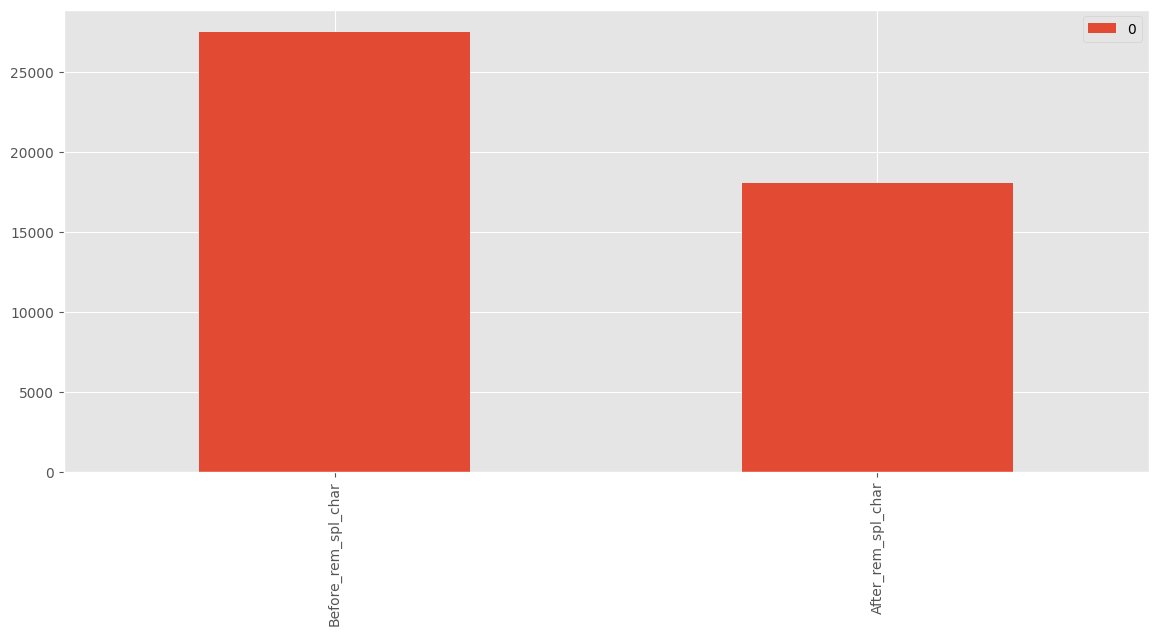

In [45]:
index = ['Before_rem_spl_char','After_rem_spl_char']
df = pd.DataFrame(data = [token_without_lc,token_with_lc],index = index)
df.plot(kind = 'bar')

#3. Stopwords and high/low frequency words
As discussed before, stopwords naturally occur very frequently in the English language without adding any context specific insights. It makes sense to remove them. Let's first review what languages are available in the nltk package:

In [46]:
from nltk.corpus import stopwords
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [47]:
noise_words = []
eng_stopword = stopwords.words('english')
eng_stopword

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

These are some removing words

In [48]:
stop_word = set(eng_stopword)
without_stopwords = []
with_stopword = []

sentence = amazon_reviews['reviews_text_new'][0]
word = nltk.word_tokenize(sentence)

for item in word:
  if item in stop_word:
    with_stopword.append(item)
  else:
    without_stopwords.append(item)


print('-- Original Sentence --\n', sentence)
print('-- Word Tokenize --\n', word)
print('\n-- Stopwords in the sentence --\n', with_stopword)
print('\n-- Non-stopwords in the sentence --\n', without_stopwords)


-- Original Sentence --
 i have bought several of the vitality canned dog food products and have found them all to be of good quality the product looks more like a stew than a processed meat and it smells better my labrador is finicky and she appreciates this product better than most 
-- Word Tokenize --
 ['i', 'have', 'bought', 'several', 'of', 'the', 'vitality', 'canned', 'dog', 'food', 'products', 'and', 'have', 'found', 'them', 'all', 'to', 'be', 'of', 'good', 'quality', 'the', 'product', 'looks', 'more', 'like', 'a', 'stew', 'than', 'a', 'processed', 'meat', 'and', 'it', 'smells', 'better', 'my', 'labrador', 'is', 'finicky', 'and', 'she', 'appreciates', 'this', 'product', 'better', 'than', 'most']

-- Stopwords in the sentence --
 ['i', 'have', 'of', 'the', 'and', 'have', 'them', 'all', 'to', 'be', 'of', 'the', 'more', 'a', 'than', 'a', 'and', 'it', 'my', 'is', 'and', 'she', 'this', 'than', 'most']

-- Non-stopwords in the sentence --
 ['bought', 'several', 'vitality', 'canned', '

In [49]:
def remove_stop_words(text):
  text1 = [word.lower() for word in text.split() if word.lower() not in eng_stopword]
  return " ".join(text1)

In [50]:
amazon_reviews['Text_after_stopwords'] = amazon_reviews['reviews_text_new'].apply(remove_stop_words)
amazon_reviews[['reviews_text_new','Text_after_stopwords'] ]

,reviews_text_new,Text_after_stopwords
0,i have bought several of the vitality canned d...,bought several vitality canned dog food produc...
1,product arrived labeled as jumbo salted peanut...,product arrived labeled jumbo salted peanuts p...
2,this is a confection that has been around a fe...,confection around centuries light pillowy citr...
3,if you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...
4,great taffy at a great price there was a wide ...,great taffy great price wide assortment yummy ...
...,...,...
9995,we switched from the advance similac to the or...,switched advance similac organic product think...
9996,like the bad reviews say the organic formula c...,like bad reviews say organic formula constipat...
9997,i wanted to solely breastfeed but was unable t...,wanted solely breastfeed unable keep supplemen...
9998,i love the fact that i can get this delieved t...,love fact get delieved house delievy charge ha...


#4. Stemming & lemmatization
Now we are ready for the last part of our pre-processing - stemming & lemmatization.

**Stemming** works by cutting off the end or the beginning of the word, taking into account a list of common prefixes and suffixes that can be found.

**Lemmatization** takes into consideration the morphological analysis of the words. So lemmatization considers the grammar of the word and tries to find the root word instead of just getting to the root word by brute force methods.

In [51]:
from nltk.stem import PorterStemmer,LancasterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [52]:
porter = PorterStemmer()
lancas = LancasterStemmer()
lemmatizer = WordNetLemmatizer()

In [53]:
print("Porter Stemmer")
print(porter.stem("buy"))
print(porter.stem("buying"))
print(porter.stem("Beautiful"))

Porter Stemmer
buy
buy
beauti


It can be seen that we get a meaning root word from Lemmatizer while Stemmer just cuts out and extracts the first important part of the word.

Optionally and depending on the context and the nature of the problem, we can apply lemmatization and stemming to our dataset as follows:

In [54]:
print("Lancaster Stemmer")
print(lancas.stem("buy"))
print(lancas.stem("buying"))
print(lancas.stem("Beautiful"))

Lancaster Stemmer
buy
buy
beauty


In [55]:
#Provide a word to be lemmetized

print("WordNet Lemmatizer")
print(lemmatizer.lemmatize("buy",wordnet.NOUN))
print(lemmatizer.lemmatize("buying",wordnet.VERB))
print(lemmatizer.lemmatize("Beautiful",wordnet.VERB))

WordNet Lemmatizer
buy
buy
Beautiful


In [56]:
def stem_terms(row):
  return [lancas.stem(term) for term in row]

def lemmatize_terms(row):
  return [lemmatizer.lemmatize(term) for term in row]


In [57]:
amazon_reviews['reviews_text_stemm'] = amazon_reviews['Text_after_stopwords'].apply(stem_terms)
amazon_reviews['reviews_text_lemma'] = amazon_reviews['Text_after_stopwords'].apply(lemmatize_terms)

In [58]:
amazon_reviews[['Text_after_stopwords','reviews_text_stemm','reviews_text_lemma']]

,Text_after_stopwords,reviews_text_stemm,reviews_text_lemma
0,bought several vitality canned dog food produc...,"[b, o, u, g, h, t, , s, e, v, e, r, a, l, , ...","[b, o, u, g, h, t, , s, e, v, e, r, a, l, , ..."
1,product arrived labeled jumbo salted peanuts p...,"[p, r, o, d, u, c, t, , a, r, r, i, v, e, d, ...","[p, r, o, d, u, c, t, , a, r, r, i, v, e, d, ..."
2,confection around centuries light pillowy citr...,"[c, o, n, f, e, c, t, i, o, n, , a, r, o, u, ...","[c, o, n, f, e, c, t, i, o, n, , a, r, o, u, ..."
3,looking secret ingredient robitussin believe f...,"[l, o, o, k, i, n, g, , s, e, c, r, e, t, , ...","[l, o, o, k, i, n, g, , s, e, c, r, e, t, , ..."
4,great taffy great price wide assortment yummy ...,"[g, r, e, a, t, , t, a, f, f, y, , g, r, e, ...","[g, r, e, a, t, , t, a, f, f, y, , g, r, e, ..."
...,...,...,...
9995,switched advance similac organic product think...,"[s, w, i, t, c, h, e, d, , a, d, v, a, n, c, ...","[s, w, i, t, c, h, e, d, , a, d, v, a, n, c, ..."
9996,like bad reviews say organic formula constipat...,"[l, i, k, e, , b, a, d, , r, e, v, i, e, w, ...","[l, i, k, e, , b, a, d, , r, e, v, i, e, w, ..."
9997,wanted solely breastfeed unable keep supplemen...,"[w, a, n, t, e, d, , s, o, l, e, l, y, , b, ...","[w, a, n, t, e, d, , s, o, l, e, l, y, , b, ..."
9998,love fact get delieved house delievy charge ha...,"[l, o, v, e, , f, a, c, t, , g, e, t, , d, ...","[l, o, v, e, , f, a, c, t, , g, e, t, , d, ..."


#Building a machine learning model
Now we have cleaned-up versions of two very important pieces of data – the actual review text and its corresponding sentiment rating:

In [59]:
#Building a machine learning model

amazon_reviews[['Text','Score','Sentimenta_scores']].head(5)

,Text,Score,Sentimenta_scores
0,I have bought several of the Vitality canned d...,5,1
1,Product arrived labeled as Jumbo Salted Peanut...,1,0
2,This is a confection that has been around a fe...,4,1
3,If you are looking for the secret ingredient i...,2,0
4,Great taffy at a great price. There was a wid...,5,1


The independent variables or model features are derived from the review text. Previously, we discussed how we can use n-grams to create features, and specifically how bag-of-words is the simplest interpretation of these n-grams, disregarding order and context entirely and only focusing on frequency/count. Let's use that as a starting point.

Conversely, reading each of the reviews, it is clear that, for instance, "good" is mentioned in context like "not as good" or "sounds good". This indicates that in the world of text we cannot go by single words (also called 1-grams) alone. The context of the sentence or the surrounding words at least are very much necessary to understand the sentiment of a sentence.


#n-grams
Since 1-grams are sometimes insufficient to understand the significance of certain words in our text, it is natural to consider blocks of words, or n-grams.

In [60]:
from nltk.util import ngrams

sentence = "A bird in the hand worths two in the bush"

for n in range(1,6):
  print(str(n) + '-grams:\n',list(ngrams(sentence.split(),n)))


1-grams:
 [('A',), ('bird',), ('in',), ('the',), ('hand',), ('worths',), ('two',), ('in',), ('the',), ('bush',)]
2-grams:
 [('A', 'bird'), ('bird', 'in'), ('in', 'the'), ('the', 'hand'), ('hand', 'worths'), ('worths', 'two'), ('two', 'in'), ('in', 'the'), ('the', 'bush')]
3-grams:
 [('A', 'bird', 'in'), ('bird', 'in', 'the'), ('in', 'the', 'hand'), ('the', 'hand', 'worths'), ('hand', 'worths', 'two'), ('worths', 'two', 'in'), ('two', 'in', 'the'), ('in', 'the', 'bush')]
4-grams:
 [('A', 'bird', 'in', 'the'), ('bird', 'in', 'the', 'hand'), ('in', 'the', 'hand', 'worths'), ('the', 'hand', 'worths', 'two'), ('hand', 'worths', 'two', 'in'), ('worths', 'two', 'in', 'the'), ('two', 'in', 'the', 'bush')]
5-grams:
 [('A', 'bird', 'in', 'the', 'hand'), ('bird', 'in', 'the', 'hand', 'worths'), ('in', 'the', 'hand', 'worths', 'two'), ('the', 'hand', 'worths', 'two', 'in'), ('hand', 'worths', 'two', 'in', 'the'), ('worths', 'two', 'in', 'the', 'bush')]


#Bag-of-words
The bag-of-words procedure falls under a broader category of techniques known as count-based representations. These are techniques to analyze documents by indicating how frequently certain types of structures occur throughout.

Let's create a word-document co-occurrence matrix for our set of reviews using the CountVectorizer class that automatically accounts for certain preprocessing steps like removing stopwords, stemming, creating n-grams, and word tokenization:

In [61]:
from sklearn.feature_extraction.text import CountVectorizer

countvec = CountVectorizer()
X = countvec.fit_transform(amazon_reviews['reviews_text_new'])
df = pd.DataFrame(X.toarray(),columns = countvec.get_feature_names_out())
df.head()

,00,000,0003,000kwh,002,008,0100,0174,02,03,...,zomg,zon,zoo,zoom,zotz,zucchini,zuke,zukes,zupas,zuppa
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's use this to create a bag of words from the reviews, excluding the noise words we identified earlier:

In [62]:
bow_counts = CountVectorizer(tokenizer = word_tokenize,
                             stop_words = noise_words,
                             ngram_range = (1,1))

bow_data = bow_counts.fit_transform(amazon_reviews['reviews_text_new'])

In [71]:
bow_data

<9138x1261413 sparse matrix of type '<class 'numpy.int64'>'
	with 2530528 stored elements in Compressed Sparse Row format>

We can see that a sparse matrix of 9138 observations (number of rows of the reviews_text_new series) has been built, and 1261413 columns corresponding to the features extracted by means of the representation of the 1-gram count of the user reviews.

Once the bag of words is prepared, the dataset should be divided into training and test sets:

In [63]:
X_train_bow,X_test_bow,y_train_bow,y_test_bow = train_test_split(bow_data,
                                                                 amazon_reviews['Sentimenta_scores'],
                                                                 test_size = 0.2,
                                                                 random_state = 0)

In [64]:
y_test_bow.value_counts()/y_test_bow.shape[0]

1    0.847921
0    0.152079
Name: Sentimenta_scores, dtype: float64

The test data contains 84% positive sentiment reviews. So, if we were to naively classify all reviews as positive, then our model would achieve an accuracy of 84%. Therefore, this is the baseline that any model we create must beat. We have an imbalance in the classes. However, we will skip the handling class imbalance processes to focus on NLP modeling. However, as an intermediate step, techniques such as SMOTE, sub-sampling or oversampling can be applied.

##Applying logistic regression
Let's train the model on our training data and run the resulting model on our test data:

Accuracy:  92.0
Precision:  94.0
Recall:  96.0
F1 score:  95.0


<Axes: >

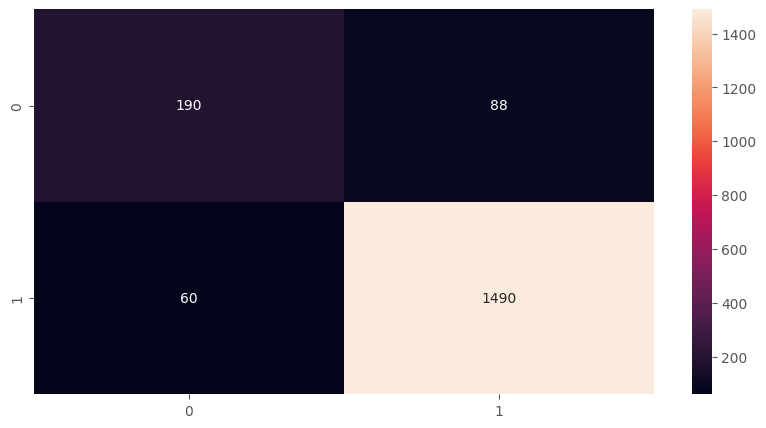

In [65]:
from nltk.tag.api import accuracy
#Applying logistic regression

logreg = LogisticRegression()
y_pred = logreg.fit(X_train_bow,y_train_bow).predict(X_test_bow)

print("Accuracy: ", round(accuracy_score(y_test_bow,y_pred),2)*100)
print("Precision: ", round(precision_score(y_test_bow,y_pred),2)*100)
print("Recall: ", round(recall_score(y_test_bow,y_pred),2)*100)
print("F1 score: ", round(f1_score(y_test_bow,y_pred),2)*100)

from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(y_test_bow,y_pred)
plt.figure(figsize = (10,5))
sns.heatmap(cm,
            annot=True,
            fmt='g')


now we are going to use biagrams,trigrams and 4-grams

Accuracy:  92.01
Precision:  92.91
Recall:  98.06
F1 score:  95.42


<Axes: >

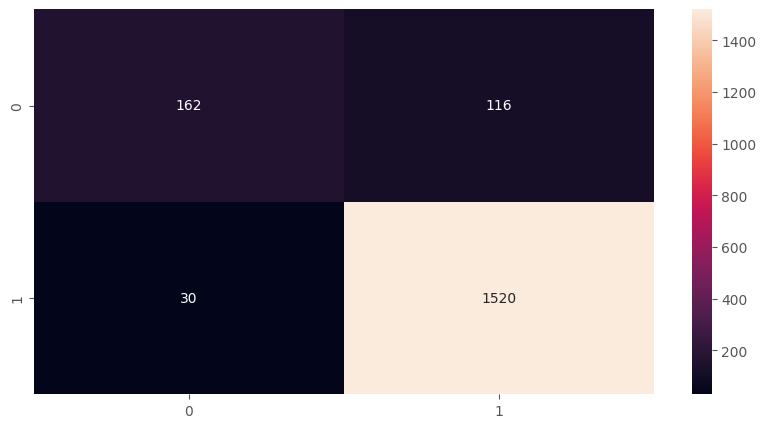

In [66]:
bow_counts = CountVectorizer(tokenizer = word_tokenize,
                             stop_words = noise_words,
                             ngram_range = (1,4))

bow_data = bow_counts.fit_transform(amazon_reviews['reviews_text_new'])

X_train_bow,X_test_bow,y_train_bow,y_test_bow = train_test_split(bow_data,
                                                                 amazon_reviews['Sentimenta_scores'],
                                                                 test_size = 0.2,
                                                                 random_state = 0)
#Applying logistic regression

logreg = LogisticRegression(max_iter = 200)
y_pred = logreg.fit(X_train_bow,y_train_bow).predict(X_test_bow)

print("Accuracy: ", round(accuracy_score(y_test_bow,y_pred),4)*100)
print("Precision: ", round(precision_score(y_test_bow,y_pred),4)*100)
print("Recall: ", round(recall_score(y_test_bow,y_pred),4)*100)
print("F1 score: ", round(f1_score(y_test_bow,y_pred),4)*100)

cm = confusion_matrix(y_test_bow,y_pred)
plt.figure(figsize = (10,5))
sns.heatmap(cm,
            annot=True,
            fmt='g')

The F1-score has jumped slightly. This is an example of what simple hyperparameter tuning and input feature modification can do to the overall performance. We can even get interpretable features from this in terms of what contributed the most to positive and negative sentiment:

In [67]:
lr_weights = pd.DataFrame(list(zip(bow_counts.get_feature_names_out(),
                                   logreg.coef_[0])),
                          columns = ['words','weights'])

df_ler_weight = lr_weights.sort_values(['weights'],ascending = False)
df_ler_weight[:10]

,words,weights
448809,great,1.327848
305794,delicious,0.952243
810997,perfect,0.838273
438773,good,0.831904
1023733,the best,0.820459
358331,excellent,0.820384
171393,best,0.792764
639088,love,0.783740
709971,nice,0.769291
930961,smooth,0.637409


In [68]:
df_ler_weight[:].sample(5)

,words,weights
814810,picky an eater,-0.007664
484999,helpful please click on,0.001724
936055,so it evens out,0.013822
994727,taste leads one,0.000000
666901,mess i made it,0.002111


#TF-IDF model

Accuracy:  89.17
Precision:  89.08
Recall:  99.42
F1 Score:  93.96


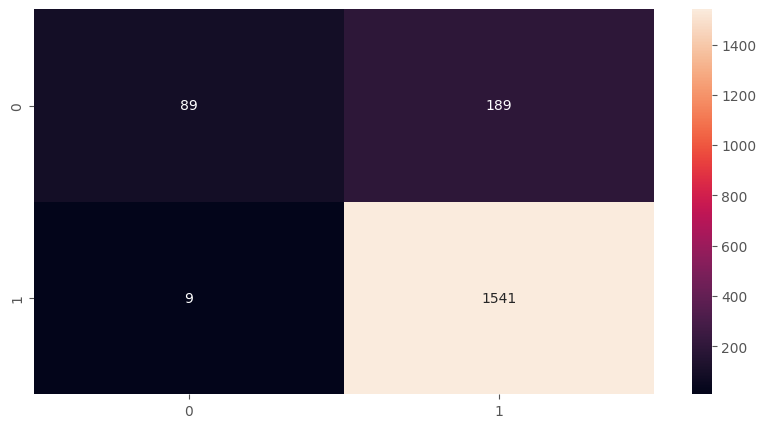

In [69]:
tfidf_counts = TfidfVectorizer(tokenizer = word_tokenize,
                               stop_words = noise_words,
                               ngram_range = (1,1))

tfidf_data = tfidf_counts.fit_transform(amazon_reviews['reviews_text_new'])
X_train_tfidf,X_test_tfidf,y_train_tfidf,y_test_tfidf = train_test_split(tfidf_data,
                                                                         amazon_reviews['Sentimenta_scores'],
                                                                         test_size = 0.2,
                                                                         random_state = 0)
#Applying logistic regression to TF-IDF features
lr_tfidf = LogisticRegression()

y_pred_tfidf = lr_tfidf.fit(X_train_tfidf,y_train_tfidf).predict(X_test_tfidf)

cm_tfidf = confusion_matrix(y_test_tfidf,y_pred_tfidf)
plt.figure(figsize = (10,5))
sns.heatmap(cm_tfidf,
            annot=True,
            fmt='g')

print("Accuracy: ", round(accuracy_score(y_test_tfidf,y_pred_tfidf),4)*100)

print("Precision: ", round(precision_score(y_test_tfidf,y_pred_tfidf),4)*100)

print("Recall: ", round(recall_score(y_test_tfidf,y_pred_tfidf),4)*100)

print("F1 Score: ", round(f1_score(y_test_tfidf,y_pred_tfidf),4)*100)

Here we have decresed slightly our F1 score value with TF-IDF as compared to the bag-of-words approach.

In [87]:
from sklearn.model_selection import GridSearchCV    
from sklearn.ensemble import RandomForestRegressor  

In [93]:
param_grid = {'n_estimators':[100,150,200],
              'min_samples_leaf':[6,4,2],
              'max_depth' : [30,20,25],
              'min_samples_split': [30,25,20],
              'max_features':['auto','sqrt','log2']
              }

clf = RandomForestRegressor()

In [94]:
ran_grid_sea = GridSearchCV(clf,param_grid,n_jobs = -1,cv= 3,verbose = 1)

In [96]:
#ran_grid_sea.fit(X_train_bow,y_train_bow)